----

# Try YAT
Source: [UnioViedo.es](https://www.unioviedo.es/compnum/labs/PYTHON/intro_image.html) 

**Image**: A coordinate system and a value at that given coordinate 
- spatial coordinates and intensity values
- $f(x,y) = \mathbb{R}$
- for color, the intensity value is a 3D vector (or 4D if alpha channel) - each index is a channel @ RGBA
- Can be continuous in (x,y) coordinates or in intensity values (analog image). OR discrete (digital image)

**Sampling and Quantization**
Convert analog to digital form. Operates on both coordinates and intensity values
- Sampling: digitizing the coordinates 
- Quantization: digitizing the intensity 
- **Interpolation**: Convert digital to analog; reverse process


## Image Types and Conversion
There are 3 main types of images: 

1. **Intensity Image:** values have been scaled to represent intensities. E.g. unit8 $=[0,255]$ range and float $=[0,1]$ range

2. **Binary Image:** black and white image. pixel value $\in{0,1}$ - logical values. 

3. **Color Image:** similar to intensity but with 2 (or 4 for alpha) channels, one for each color in R, G, B. 

**Data type selection**: Pref to have float types during math operations and then uint types during saving/io operations. Int codification saves on space. 
- `np.asarray( <ur_img_data>, dtype=np.float32)`
- `skimage.img_as_float(<ur_img_data>)`


## Image Operations 
**Basics Matrix Manipulation**:
- slicing, indexing, 


In [1]:
%run "000_shared_lib.ipynb"

"---Image Stats---\n Shape: (700, 525) \n Type: <class 'numpy.ndarray'> \n Mean: 0.5419929876953448 \n Median: 0.5253035294117647 \n Max: 1.0 \n Min: 0.0 "

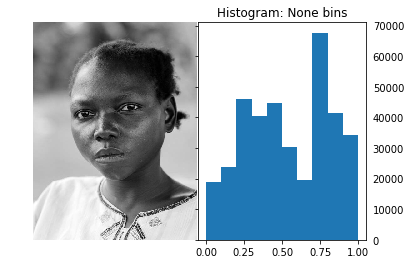

In [69]:
img2 = AnImage("media/img3.jpeg", True)
img2.show()
img2.stats

"---Image Stats---\n Shape: (512, 512, 3) \n Type: <class 'numpy.ndarray'> \n Mean: 119.73804728190105 \n Median: 117.0 \n Max: 255 \n Min: 0 "

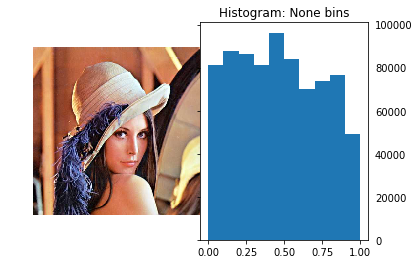

In [7]:
img = AnImage("media/lena.jpg", isgray=False)
img.show(cmap=None)
img.stats

"---Image Stats---\n Shape: (512, 512) \n Type: <class 'numpy.ndarray'> \n Mean: 118.31400299072266 \n Median: 142.0 \n Max: 255 \n Min: 0 "

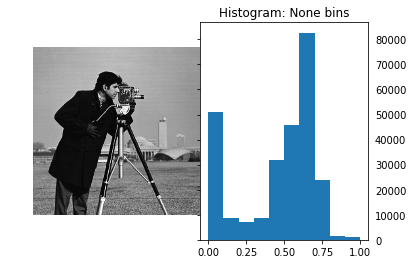

In [96]:
img3 = AnImage('media/cameraman.tif')
img3.stats
img3.show()

In [266]:
def subset_image_perc(img, start_tuple, perc_w, show=True):
    h, w = img.shape 
    sw = int(w*perc_w)
    sh = int(h*( (h/w)*perc_w ))  
    return subset_image_size(img, start_tuple, (sh,sw), show)

def subset_image_w(img, start_tuple, sw, show=True):
    h, w = img.shape 
    sh = int(h*( (h/w)*sw ))    
    return subset_image_size(img, start_tuple, (sh,sw), show)

def subset_image_size(img, start_tuple, size_tuple, show=True):
    h,w = img.shape
    sr, sc = start_tuple
    er, ec = np.min(sr+size_tuple[0],h), np.min(sc+size_tuple[1],w)
    return subset_image(img, start_tuple, (er,ec), show)

def subset_image(img, start_tuple, end_tuple, show=True):
    sr, sc = start_tuple
    er, ec = end_tuple
    outsie = img.copy()[sr:sc, er:ec]
    
    if show:
        show_image_list([img, outsie], titlez=['origi', 'subset'])
    
    return outsie

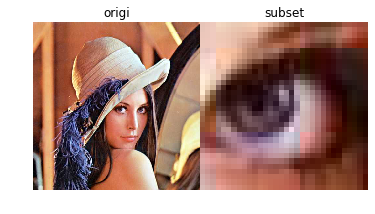

In [267]:
o = subset_image(img.img, (251, 283), (317, 349) )

In [131]:
#subset_image_perc(img2.img, (320, 420), 0.1)

In [132]:
#subset_image(img.img, (20, 20), (200, 400))

/home/moranis/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:855: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)
/home/moranis/anaconda3/lib/python3.7/site-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


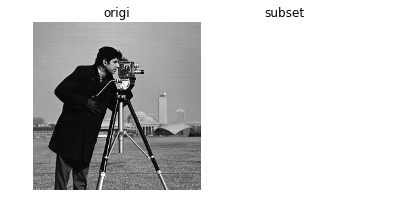

In [268]:
o = subset_image(img3.img, (70, 70), (483, 483) )

---
## Masks
**Masks** are geometric filters on an image
- **Extraction:** to extract a region of an image, use boolean filter with areas of interest set to 1 and everything else to 0.


In [265]:
def circular_mask(img, radius=0.4, center=True, show=True, fill=0):
    ## draw circle on coordinate system 
    # 1. get center of image 
    if len(img.shape) > 2:
        nr, nc, _ = img.shape 
    else:
        nr, nc = img.shape 
    cx, cy = int(nc//2), int(nr//2)
    
    # 2. generate mask of given radius @ pythog and trigonometry
    # (j - cx)^2 + (i - cy)^2 < radius^2
    mask = np.zeros_like( img )
    
    
    def calc_thresh():
        r = int(radius*nc) 
        return r**2
        
    def fill_mask(i,j,val):        
        if len(img.shape) > 2:
            mask[i,j,:] = val
        else:
            mask[i,j] = val
    
    radius_thresh = calc_thresh()
    
    for i in range(nr):
        for j in range(nc):
            ij_thresh = (j-cx)**2+(i-cy)**2
            if ij_thresh <= radius_thresh:
                fill_mask(i, j, 1)
            else:
                fill_mask(i, j, fill)
                
    # 3. apply mask on image
    outsie = mask* skimage.img_as_float(img)
    #outsie = skimage.img_as_uint8( outsie )
    
    if show:
        show_image_list([img, outsie], titlez=['origi', 'masked'])
    
    return outsie
    

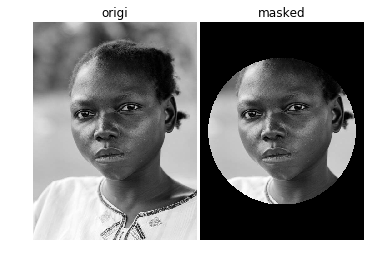

In [269]:
o = circular_mask(img2.img, radius=0.45)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


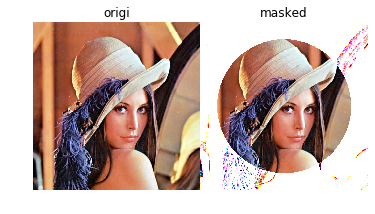

In [270]:
o = circular_mask(img.img, fill=15)

## Filter - Linear Degradation
Effect of darkening and image vertically or horizontally
- a mask that is constant by columns (or row iff vertical) and with decreasing values in rows (from 1 to 0)
- 

In [264]:
def linear_degradation(img, vert=True, show=True):        
    if len(img.shape) > 2:
        h, w, _ = img.shape 
    else:
        h, w = img.shape 
    # 1. gen evenly spaced numbers over interval     
    def gen_mask():
        int_size = w if vert else h
        repeats = h if vert else w
        mshape = (-1, int_size) if vert else (int_size, -1)
        # set it up
        interval = np.linspace(0, 1, num=int_size)
        # tile it         
        mask =  np.tile( interval, repeats)
        return mask.reshape(*mshape)       
        
    
    # 2. apply mask of evenly spaced constants by row or col
    outsie = img.copy() 
    if len(img) >2:
        outsie = gen_mask()*skimage.img_as_float( skimage.color.rgb2gray(outsie) )
        outsie = skimage.color.gray2rgb(outsie) ##TODO: presever information 
    else:
        outsie = gen_mask()*skimage.img_as_float(outsie)
    
    
    if show:
        show_image_list([img, outsie], titlez=['origi', 'linear degrade'])
    
    return outsie

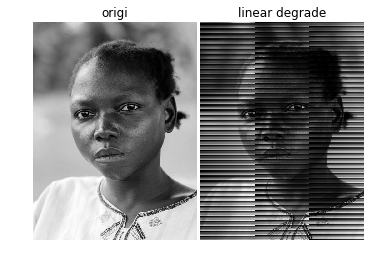

In [271]:
o = linear_degradation(img2.img, vert=False)

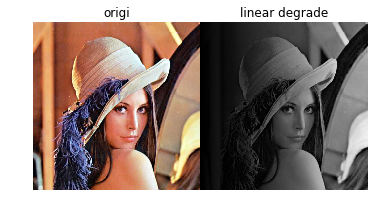

In [272]:
o = linear_degradation(img.img, vert=True)

In [263]:
def checkerboard(w, n=8, show=True):
    outsie = np.zeros((w,w))
    tw = w//n
    
    def make_tile(i,j):
        #outsie[i:j, (i+tw):(j+tw)] = 1
        tile_n_r = i//tw
        tile_n_c = j//tw
        ## TODO: reduce code @ if loops 
        if (tile_n_c % 2 == 0):
            if tile_n_r %2 == 0:
                return 1
            else:
                return 0
                
        if (tile_n_c % 2 == 1):
            if tile_n_r %2 == 1:
                return 1
            else:
                return 0
        
    ##TODO: vectorization 
    for i in range(w):
        for j in range(w):
            outsie[i,j] = make_tile(i,j)    
    
    if show:
        show_image_list([outsie], titlez=['Checker board'])
    
    return outsie
    

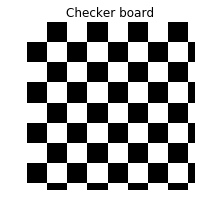

In [277]:
o = checkerboard(100) #250*8) ##TODO: optimize code at speed if large file size required

#skimage.io.imsave('checkerboard.png', o)

In [484]:
def fan_rings(w, n=8, show=True): 
    tw = ((w/2)//n)
    cx, cy = w//2, w//2
    print(f"tw:{tw}\t cx,cy:{cx},{cy}")
    def get_radius(i,j):
        return np.abs( ((i-cx)**2) + ((j-cy)**2) )#**(0.5)
    
    ring_thresh = get_radius(cx+tw, cy+tw)
    print(f"ring_thresh: {ring_thresh}")
    def make_ring(i,j):        
        tr = get_radius(i, j)
        ring_n = (tr//ring_thresh)
#         print(f"tr: {tr}\t tw: {tw}\t ring_n:{ring_n}\t ring_thres: {ring_thresh}")
        ## if even: dark else light
#         print(f"{ring_n}", end=" ")
        if ring_n % 2 == 0:
            return 1
        else:
            return 0
    outsie = np.zeros((w,w))
    for i in range(w):
        for j in range(w):
            outsie[i,j] = make_ring(i,j)
        
    if show:
        show_image_list([outsie], titlez=['Fan rings'])
    
    return outsie

def concentric_rings(w, n=8, show=True): 
    tw = ((w/2)//n)
    cx, cy = w//2, w//2
    print(f"tw:{tw}\t cx,cy:{cx},{cy}")
    def get_radius(i,j):
        return np.abs( ((i-cx)**2) + ((j-cy)**2) )**(0.5)
    
    ring_thresh = get_radius(cx+tw, cy+tw)
    print(f"ring_thresh: {ring_thresh}")
    def make_ring(i,j):        
        tr = get_radius(i, j)
        ring_n = (tr//ring_thresh)
#         print(f"tr: {tr}\t tw: {tw}\t ring_n:{ring_n}\t ring_thres: {ring_thresh}")
        ## if even: dark else light
#         print(f"{ring_n}", end=" ")
        if ring_n % 2 == 0:
            return 1
        else:
            return 0
    outsie = np.zeros((w,w))
    for i in range(w):
        for j in range(w):
            outsie[i,j] = make_ring(i,j)
        
    if show:
        show_image_list([outsie], titlez=['Concentric rings'])
    
    return outsie


tw:6.0	 cx,cy:50,50
ring_thresh: 72.0


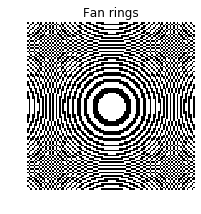

In [485]:
o = fan_rings(100)

tw:5.0	 cx,cy:50,50
ring_thresh: 7.0710678118654755


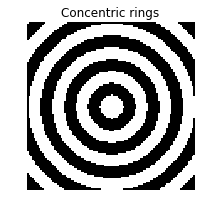

In [509]:
o = concentric_rings(100, 10)

In [510]:
def napkin(w, n=5, show=True):    
#     outsie = checkerboard(w, 8, False)
#     outsie = np.zeros((w,w))    
    
    tw = w//n
    print(f"tw = {tw}")
    
    def make_motif():
        marray = np.zeros((tw, tw) , dtype=np.float)
        twm = tw//2
        
        print(f"twm = {twm}")
        def get_pix(i,j):
            if j < twm:
                if i< twm:
                    return 0
                else:
                    return 0.5
            else:
                if i < twm:
                    return 0.5
                else:
                    return 1
                
        for i in range(tw):
            for j in range(tw):
                marray[i,j] = get_pix(i, j)                
                
        return marray
    
    outsie = np.tile( make_motif(), (n)**2 ).reshape(-1,n) 
    #outsie = checkerboard(w,n,False)*outsie
    
    print( outsie.shape )
     
    if show:
        show_image_list([outsie], titlez=['Napkin board'])
    
    return outsie
    

tw = 2
twm = 1
(20, 5)


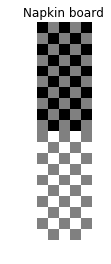

In [457]:
o = napkin(10)

tw:32.0	 cx,cy:256,256
ring_thresh: 45.254833995939045


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


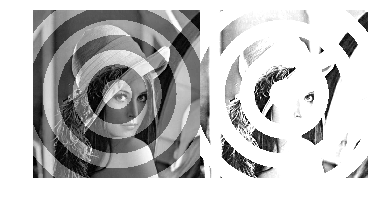

In [519]:
gimg = skimage.color.rgb2gray(img.img)*2
t1 = gimg+concentric_rings(gimg.shape[0], show=False)
t2 = skimage.color.gray2rgb(t1)
show_image_list([t1, t2])